# 0号门cv值cut结果   混淆矩阵

In [26]:
# -*- coding: utf-8 -*-
import pandas as pd
#import pymysql
#pymysql.install_as_MySQLdb()
import MySQLdb as sql
import sklearn.mixture as mix
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

#不输出警告
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
import pickle
from sklearn.externals import joblib

### 自定义函数


#### auc的混淆矩阵 输入为1维没有进行onehot编码的y

In [2]:
labels = [u'health', u'Subhealth', u'malfunction']
%matplotlib inline 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12, 8), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def CalculationResults(val_y,y_val_pred,simple = False,\
                       target_names = labels):
    # 计算检验
    F1_score = f1_score(val_y,y_val_pred, average='macro')
    if simple:
        return F1_score
    else:
        acc = accuracy_score(val_y,y_val_pred)
        recall_score_ = recall_score(val_y,y_val_pred, average='macro')
        confusion_matrix_ = confusion_matrix(val_y,y_val_pred)
        class_report = classification_report(val_y, y_val_pred, target_names=target_names)
        print('f1_score:',F1_score,'ACC_score:',acc,'recall:',recall_score_)
        print('\n----class report ---:\n',class_report)
        #print('----confusion matrix ---:\n',confusion_matrix_)

        # 画混淆矩阵
        # 画混淆矩阵图
        plt.figure()
        plot_confusion_matrix(confusion_matrix_, target_names,
                              title='Confusion matrix, without normalization')
        plot_confusion_matrix(confusion_matrix_, target_names, True,
                              title='Normalized confusion matrix')
        plt.show()
        return F1_score,acc,recall_score_,confusion_matrix_,class_report


In [4]:
#连接外部数据库
config = {'user': 'root',
             'passwd': 'ABCabc123',
             'host': '10.84.1.20',
             'db': 'maoqing',
             'charset':'utf8'}
database='door_data_can0812'

#while(1):
#链接数据库读取新数据
conn = sql.connect(**config)
cur = conn.cursor(cursorclass=sql.cursors.DictCursor)#返回字段名

In [5]:
#读取所有cv_lable为null的行
sql_statement="select * from "+database+" where CV is not null and GATE = 0 and actual_result is not null"
rawdata_can=pd.read_sql(sql_statement,conn)
rawdata_can.head()
#将HAPPENTIME列属性改为时间，并设置为index        
rawdata_can['HAPPENTIME']=pd.to_datetime(rawdata_can['HAPPENTIME'])
rawdata_can=rawdata_can.set_index('HAPPENTIME')
# rawdata_can=rawdata_can.set_index('id')
rawdata_can.shape
rawdata_can.head()

,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,HAPPENTIME,SEQ_ID,...,ID_SUM_N,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result
id,,,,,,,,,,,,,,,,,,,,,
1361020,MJYXSJID-892155,2019-03-11 12:00:14,2019-03-11 12:00:14,2019-03-11 12:00:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,2019-03-11 12:00:14,SEQ_ID,...,82877,0010011000100111,166,BAK1,Bak2,0.868374,1,0.0,正常,0
1361027,MJYXSJID-892162,2019-03-11 12:00:43,2019-03-11 12:00:43,2019-03-11 12:00:43,20170830,ELE_ID,DEVICE_ID,COMM_PORT,2019-03-11 12:00:43,SEQ_ID,...,78859,0010100100101011,-5,BAK1,Bak2,0.983516,1,0.0,正常,0
1361038,MJYXSJID-892173,2019-03-11 12:01:14,2019-03-11 12:01:14,2019-03-11 12:01:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,2019-03-11 12:01:14,SEQ_ID,...,74343,0010011000100111,165,BAK1,Bak2,0.908374,1,0.0,正常,0
1361045,MJYXSJID-892180,2019-03-11 12:01:43,2019-03-11 12:01:43,2019-03-11 12:01:43,20170830,ELE_ID,DEVICE_ID,COMM_PORT,2019-03-11 12:01:43,SEQ_ID,...,64693,0010100100101011,-5,BAK1,Bak2,0.989525,1,0.0,正常,0
1361056,MJYXSJID-892191,2019-03-11 12:02:14,2019-03-11 12:02:14,2019-03-11 12:02:14,20170830,ELE_ID,DEVICE_ID,COMM_PORT,2019-03-11 12:02:14,SEQ_ID,...,75682,0010011000100111,167,BAK1,Bak2,0.817862,1,0.0,正常,0


In [14]:
rawdata_can['HAPPENTIME']=pd.to_datetime(rawdata_can['HAPPENTIME'])
rawdata_can=rawdata_can.set_index('HAPPENTIME')

In [15]:
rawdata_can.groupby('actual_result').count()

,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,GATE,...,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,predicte_result,actual_result_num,actual_result_num1
actual_result,,,,,,,,,,,,,,,,,,,,,
人为档门,417,417,417,417,417,417,417,417,417,417,...,417,417,417,417,417,417,417,417,417,417
导轨摩擦,3594,3594,3594,3594,3594,3594,3594,3594,3594,3594,...,3594,3594,3594,3594,3594,3594,3594,3594,3594,3594
导轨轻微摩擦,35665,35665,35665,35665,35665,35665,35665,35665,35665,35665,...,35665,35665,35665,35665,35665,35665,35665,35665,35665,35665
异物档门,8453,8453,8453,8453,8453,8453,8453,8453,8453,8453,...,8453,8453,8453,8453,8453,8453,8453,8453,8453,8453
挂轮磨损,194479,194479,194479,194479,194479,194479,194479,194479,194479,194479,...,194479,194479,194479,194479,194479,194479,137703,137703,194479,194479
正常,19926,19926,19926,19926,19926,19926,19926,19926,19926,19926,...,19926,19926,19926,19926,19926,19926,19926,19926,19926,19926
滑块磨损A,84494,84494,84494,84494,84494,84494,84494,84494,84494,84494,...,84494,84494,84494,84494,84494,84494,72715,72715,84494,84494
滑块磨损B,31314,31314,31314,31314,31314,31314,31314,31314,31314,31314,...,31314,31314,31314,31314,31314,31314,31304,31304,31314,31314
滑块磨损C,19834,19834,19834,19834,19834,19834,19834,19834,19834,19834,...,19834,19834,19834,19834,19834,19834,19829,19829,19834,19834


In [16]:
rawdata_can['actual_result_num']=rawdata_can['actual_result'].astype('category')
rawdata_can['actual_result_num'].cat.categories=[6,4,1,5,10,0,2,3,7,8,9]
rawdata_can['actual_result_num']=rawdata_can['actual_result_num'].astype(int)
rawdata_can.groupby('actual_result_num').count()

,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,GATE,...,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result,actual_result_num1
actual_result_num,,,,,,,,,,,,,,,,,,,,,
0,19926,19926,19926,19926,19926,19926,19926,19926,19926,19926,...,19926,19926,19926,19926,19926,19926,19926,19926,19926,19926
1,35665,35665,35665,35665,35665,35665,35665,35665,35665,35665,...,35665,35665,35665,35665,35665,35665,35665,35665,35665,35665
2,84494,84494,84494,84494,84494,84494,84494,84494,84494,84494,...,84494,84494,84494,84494,84494,84494,72715,84494,72715,84494
3,31314,31314,31314,31314,31314,31314,31314,31314,31314,31314,...,31314,31314,31314,31314,31314,31314,31304,31314,31304,31314
4,3594,3594,3594,3594,3594,3594,3594,3594,3594,3594,...,3594,3594,3594,3594,3594,3594,3594,3594,3594,3594
5,8453,8453,8453,8453,8453,8453,8453,8453,8453,8453,...,8453,8453,8453,8453,8453,8453,8453,8453,8453,8453
6,417,417,417,417,417,417,417,417,417,417,...,417,417,417,417,417,417,417,417,417,417
7,19834,19834,19834,19834,19834,19834,19834,19834,19834,19834,...,19834,19834,19834,19834,19834,19834,19829,19834,19829,19834
8,34427,34427,34427,34427,34427,34427,34427,34427,34427,34427,...,34427,34427,34427,34427,34427,34427,34418,34427,34418,34427


In [31]:
rawdata_can_open1=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(0))].loc[:'2019-04-01',:]
rawdata_can_open2=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(0))&(rawdata_can['DOOR_STATE_Z'].astype(str)=='0010011000100111')].loc['2019-04-02':,:]
rawdata_can_open=rawdata_can_open1.append(rawdata_can_open2)

rawdata_can_close=rawdata_can[((rawdata_can['DOOR_STATE'].astype(str)=='0010101100101010')^(rawdata_can['DOOR_STATE'].astype(str)=='0010101100100011'))&(rawdata_can['GATE'].astype(str)==str(0))]

In [32]:
#找到人工标签状态变化的位置
find_change_df=pd.DataFrame(rawdata_can['actual_result_num'])
find_change_df=find_change_df.diff().dropna()
find_change_df=find_change_df['actual_result_num'].astype('int')
find_change_df=find_change_df[find_change_df!=0]
find_change_df

HAPPENTIME
2019-03-18 13:00:14    4
2019-03-19 06:00:41   -3
2019-03-26 11:40:01    4
2019-03-29 10:20:02    1
2019-03-29 16:00:11   -2
2019-03-30 05:01:14   -3
2019-04-04 12:00:11    1
2019-04-29 12:00:29    1
2019-05-10 12:33:05    4
2019-05-17 10:30:10    1
2019-05-29 13:00:05    1
2019-06-19 12:38:45    1
Name: actual_result_num, dtype: int32

In [33]:
labels = [u'正常', '导轨轻微摩擦',u'滑块磨损A', u'滑块磨损B','导轨摩擦','异物档门','人为档门','滑块磨损c','风压故障A-风扇','风压故障B-正压力','挂轮磨损']


#### 短周期判断故障状态（lable=2）

Text(0.5, 1.0, 'Health value of elevator door')

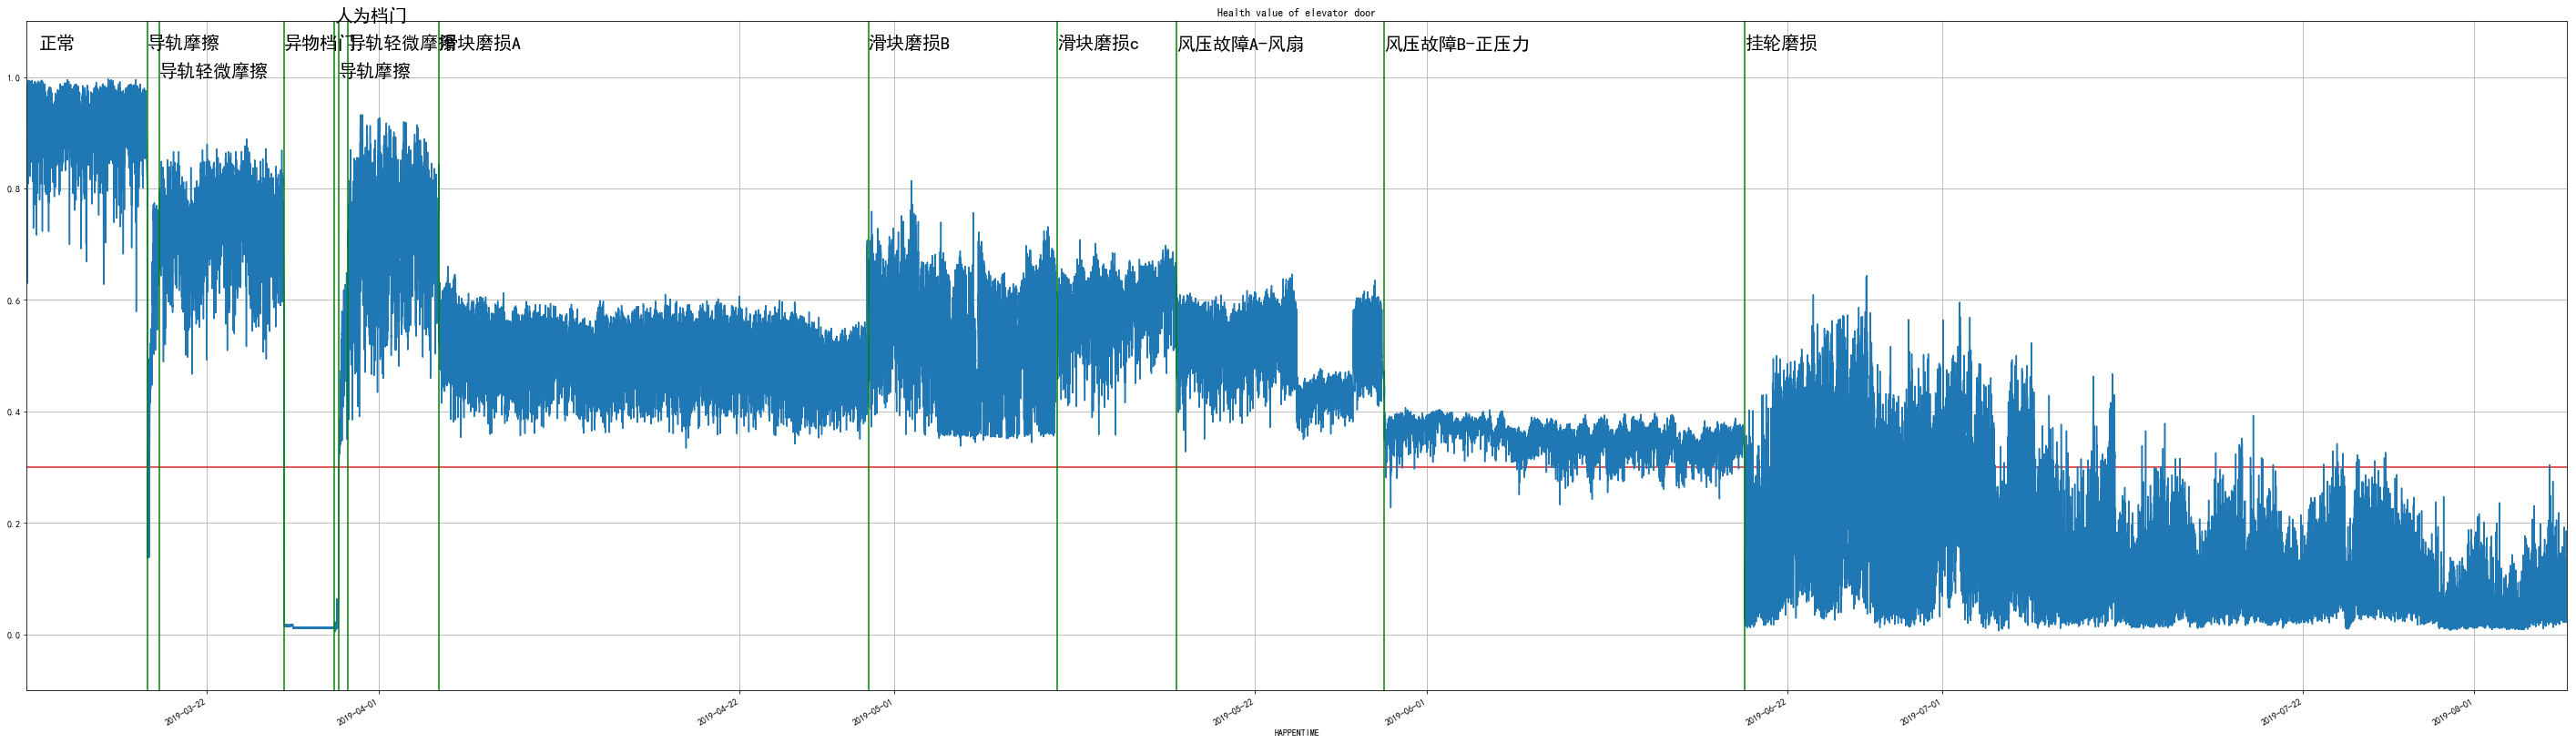

In [34]:
short_rolling_data_open=rawdata_can_open.loc[:,'CV'].rolling(5,min_periods=1).mean()
cv_label_2_open=pd.cut(short_rolling_data_open,[0,0.3,1],labels=[2,0]).astype(int)
short_rolling_data_open.head()

plt.figure(figsize=(50,15))
plt.xlim(short_rolling_data_open.index[0],short_rolling_data_open.index[-1])
plt.ylim((-0.1,1.1))#确认一下
plt.axhline(y=0.3, color='#d62728')#画横线y=0.3
short_rolling_data_open.plot()
# cv_label_2_open.plot()
#状态标记
#画标记时刻线
for i in range(len(find_change_df)):
    plt.axvline(x=find_change_df.index[i], color='g')
plt.text(rawdata_can_open.index[1000], 1.05, labels[0], fontsize=20)
plt.text(find_change_df.index[0], 1.05, labels[4], fontsize=20)
plt.text(find_change_df.index[1], 1.00, labels[1], fontsize=20)
plt.text(find_change_df.index[2], 1.05, labels[5], fontsize=20)
plt.text(find_change_df.index[3], 1.10, labels[6], fontsize=20)
plt.text(find_change_df.index[4], 1.00, labels[4], fontsize=20)
plt.text(find_change_df.index[5], 1.05, labels[1], fontsize=20)
plt.text(find_change_df.index[6], 1.05, labels[2], fontsize=20)
plt.text(find_change_df.index[7], 1.05, labels[3], fontsize=20)
plt.text(find_change_df.index[8], 1.05, labels[7], fontsize=20)
plt.text(find_change_df.index[9], 1.05, labels[8], fontsize=20)
plt.text(find_change_df.index[10], 1.05, labels[9], fontsize=20)
plt.text(find_change_df.index[11], 1.05, labels[10], fontsize=20)
plt.grid()
plt.title('Health value of elevator door')

#### 长周期判断故障状态（lable=1）

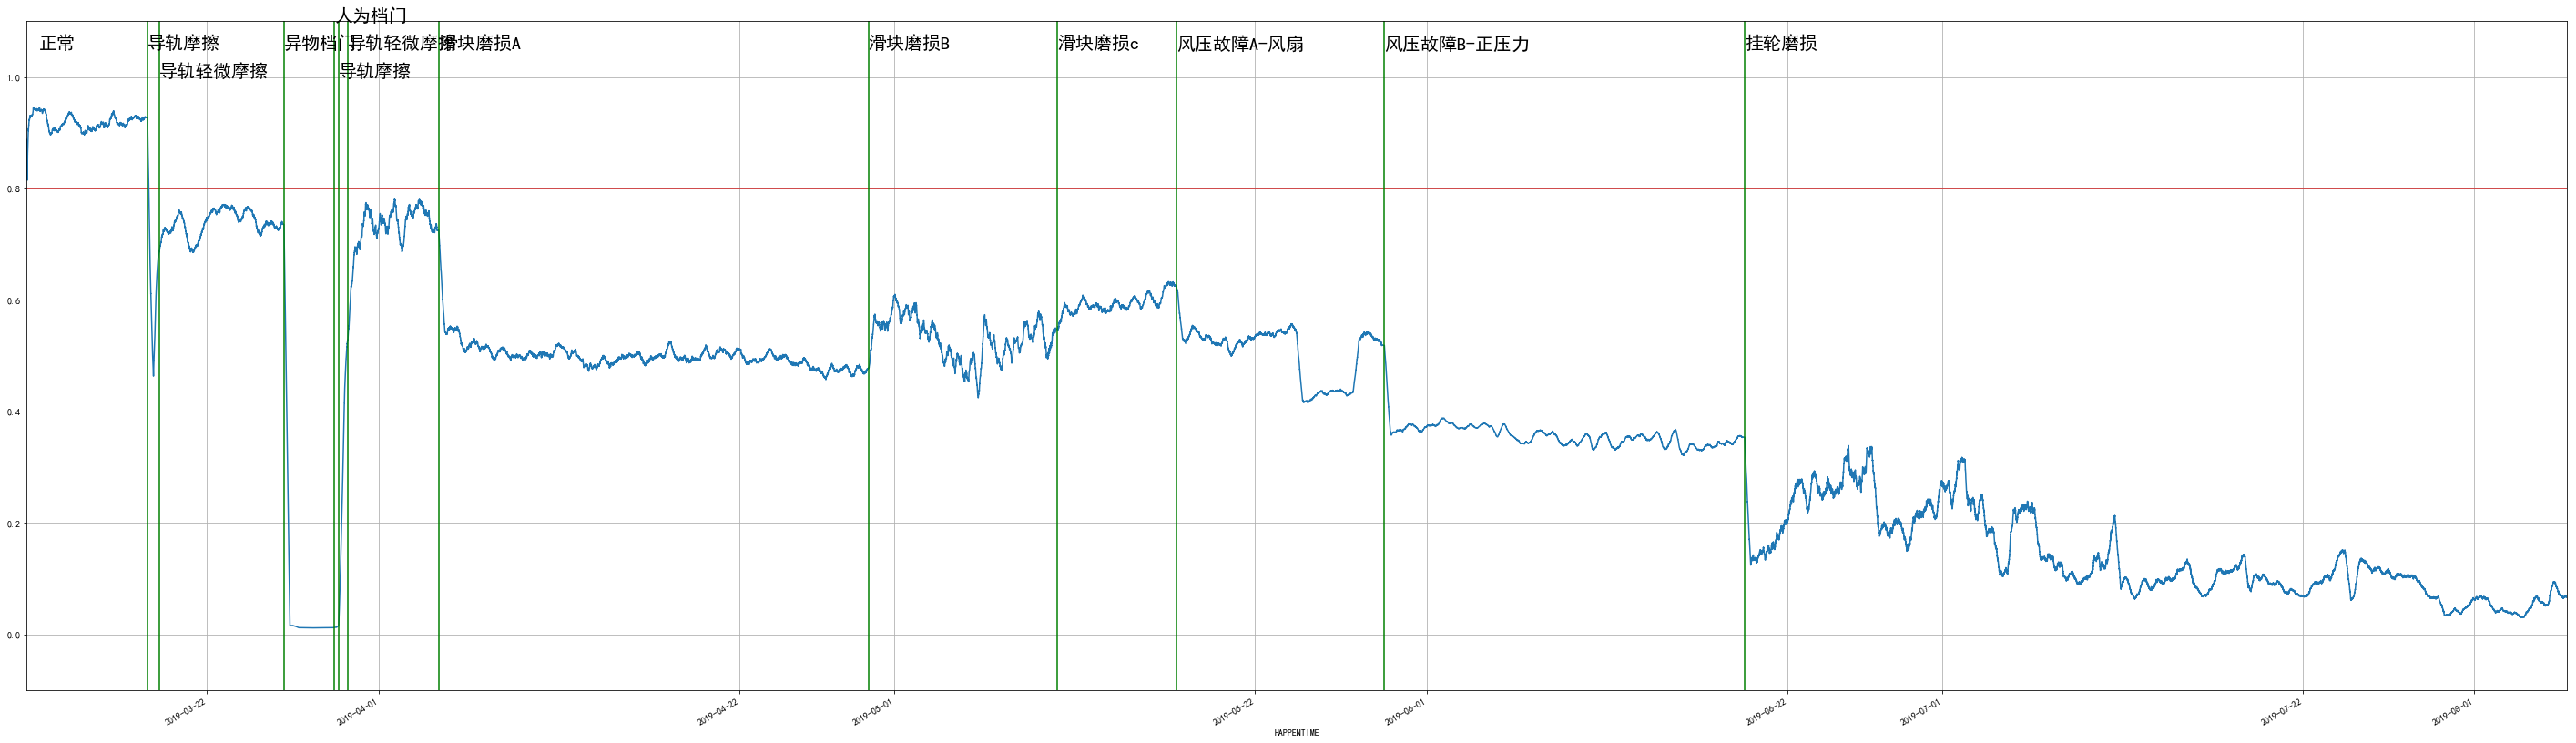

In [35]:
long_rolling_data_open=rawdata_can_open.loc[:,'CV'].rolling(500,min_periods=1).mean()
cv_label_1_open=pd.cut(long_rolling_data_open,[0,0.8,1],labels=[1,0]).astype(int)  #0-0.8为1（功能降低状态）0.8-1为0（健康状态）
long_rolling_data_open.head()

plt.figure(figsize=(50,15))
plt.xlim(long_rolling_data_open.index[0],long_rolling_data_open.index[-1])
plt.ylim((-0.1,1.1))#确认一下
plt.axhline(y=0.8, color='#d62728')#画横线
# plt.axhline(y=0.7, color='#d62728')#画横线
long_rolling_data_open.plot()
# cv_label_1_open.plot()

#状态标记
#画标记时刻线
for i in range(len(find_change_df)):
    plt.axvline(x=find_change_df.index[i], color='g')
plt.text(rawdata_can_open.index[1000], 1.05, labels[0], fontsize=20)
plt.text(find_change_df.index[0], 1.05, labels[4], fontsize=20)
plt.text(find_change_df.index[1], 1.00, labels[1], fontsize=20)
plt.text(find_change_df.index[2], 1.05, labels[5], fontsize=20)
plt.text(find_change_df.index[3], 1.10, labels[6], fontsize=20)
plt.text(find_change_df.index[4], 1.00, labels[4], fontsize=20)
plt.text(find_change_df.index[5], 1.05, labels[1], fontsize=20)
plt.text(find_change_df.index[6], 1.05, labels[2], fontsize=20)
plt.text(find_change_df.index[7], 1.05, labels[3], fontsize=20)
plt.text(find_change_df.index[8], 1.05, labels[7], fontsize=20)
plt.text(find_change_df.index[9], 1.05, labels[8], fontsize=20)
plt.text(find_change_df.index[10], 1.05, labels[9], fontsize=20)
plt.text(find_change_df.index[11], 1.05, labels[10], fontsize=20)

plt.grid()


#### 故障与不正常状态合并，取max

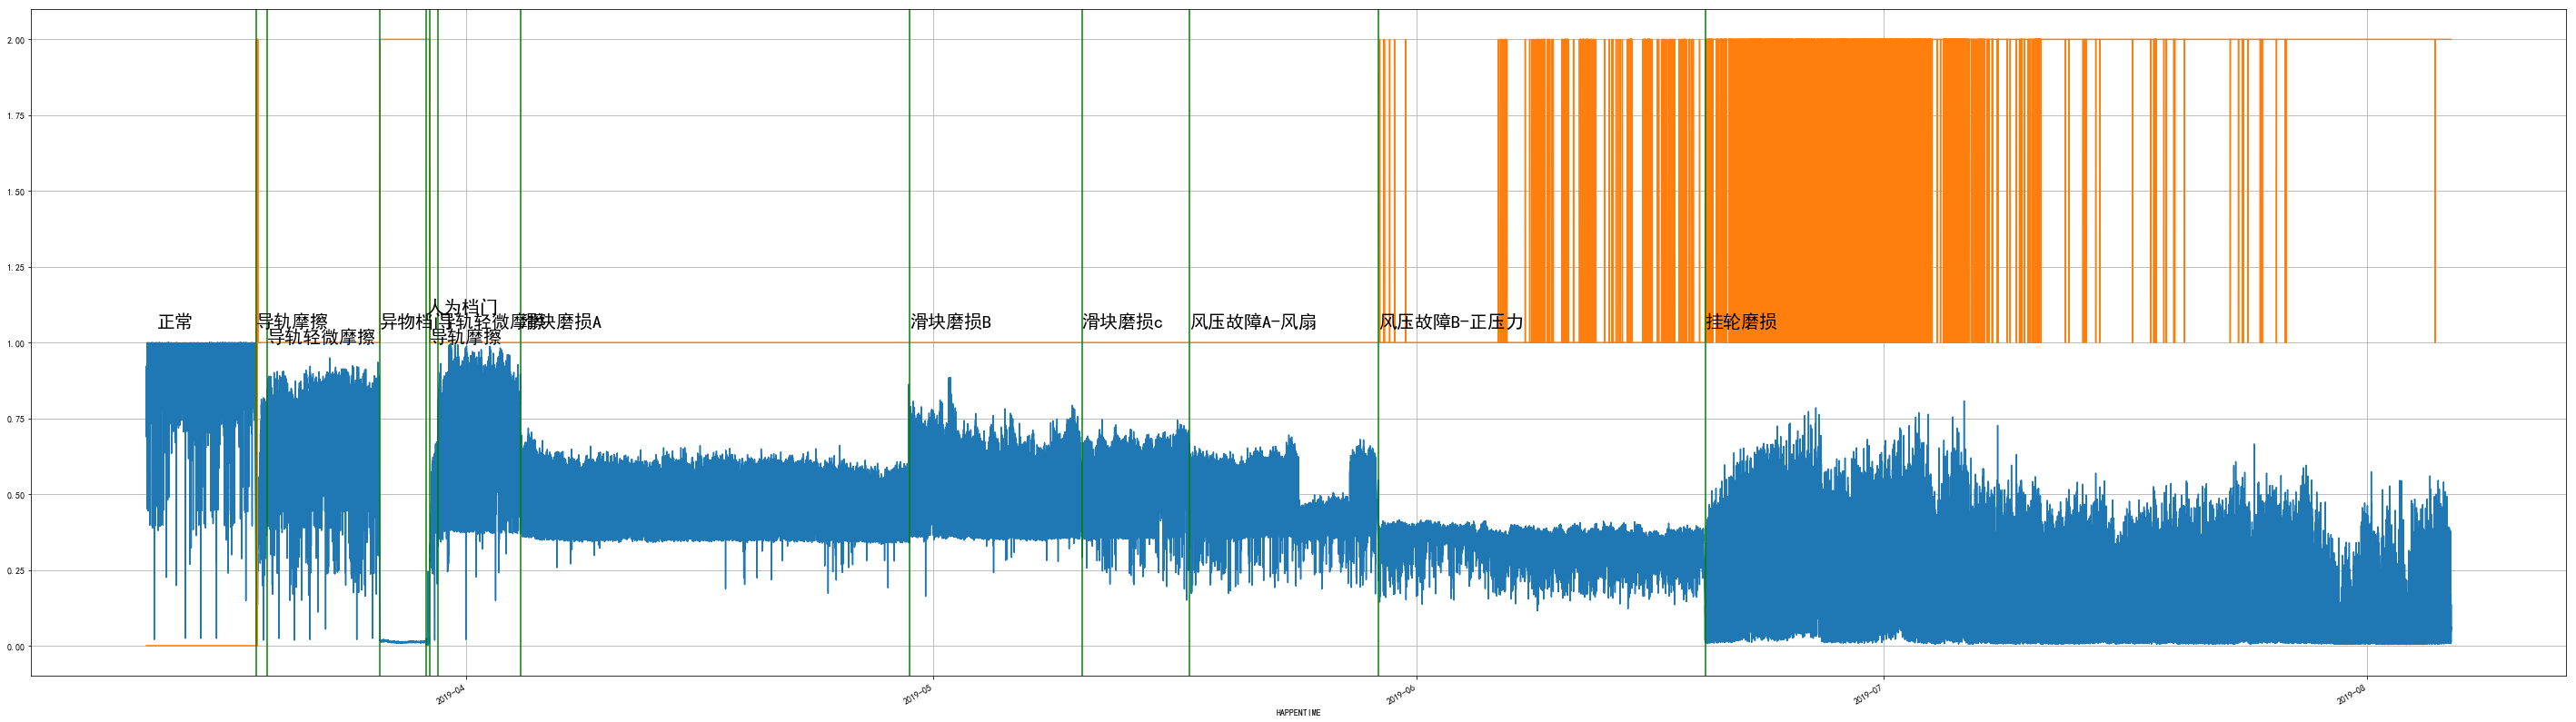

In [36]:
cv_label_open_df= pd.DataFrame([cv_label_2_open,cv_label_1_open]).T
cv_label_open=cv_label_open_df.max(1)

plt.figure(figsize=(50,15))
plt.ylim((-0.1,2.1))#确认一下
rawdata_can_open.loc[:,'CV'].plot()
cv_label_open.plot()

#状态标记
#画标记时刻线
for i in range(len(find_change_df)):
    plt.axvline(x=find_change_df.index[i], color='g')
plt.text(rawdata_can_open.index[1000], 1.05, labels[0], fontsize=20)
plt.text(find_change_df.index[0], 1.05, labels[4], fontsize=20)
plt.text(find_change_df.index[1], 1.00, labels[1], fontsize=20)
plt.text(find_change_df.index[2], 1.05, labels[5], fontsize=20)
plt.text(find_change_df.index[3], 1.10, labels[6], fontsize=20)
plt.text(find_change_df.index[4], 1.00, labels[4], fontsize=20)
plt.text(find_change_df.index[5], 1.05, labels[1], fontsize=20)
plt.text(find_change_df.index[6], 1.05, labels[2], fontsize=20)
plt.text(find_change_df.index[7], 1.05, labels[3], fontsize=20)
plt.text(find_change_df.index[8], 1.05, labels[7], fontsize=20)
plt.text(find_change_df.index[9], 1.05, labels[8], fontsize=20)
plt.text(find_change_df.index[10], 1.05, labels[9], fontsize=20)
plt.text(find_change_df.index[11], 1.05, labels[10], fontsize=20)

plt.grid()